In [1]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, random_split
from pdb import set_trace as breakpoint
from time import time

import numpy as np
import matplotlib.pyplot as plt
import h5py

from datasets.generators1d import * 
from models.utils import pbar, tensor_diff, tensor_roll

In [2]:
OMEGA = 1.215e15
MU0 = 4 * np.pi * 10**-7
EPSILON0 =  8.854187817620e-12 
SCALE = 1e-15
C = 299792458.0
L0 = 1e-6
PIXEL_SIZE = 0.05 * L0
wavelength = 2 * np.pi * C / OMEGA

## Cavity experiments

In [15]:
# perms = np.ones(65)
perms = perm_alternating_layers(s=65)
epsilons, src_x, _, _, Ez = Cavity1D(cavity_buffer=16).solve(perms, omega=OMEGA_1550)

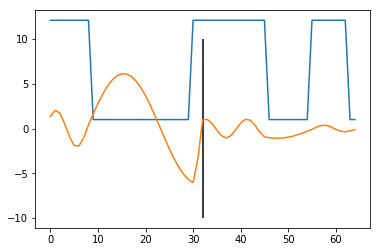

In [16]:
plt.plot(epsilons[16:-16])
plt.plot(np.real(Ez)[16:-16], label="$E_\mathrm{true}$")
plt.vlines(src_x, -10, 10)
plt.show()


In [17]:
a = torch.tensor(np.real(Ez)[16:-16])
roll=tensor_roll(a, 1)
dif = tensor_diff(a, n=2, cyclic=True)

zero = torch.tensor([0.0]).double()
# dif2 = torch.cat([zero,tensor_diff(a, n=2, padding=None), zero],dim=-1)
dif2=tensor_diff(a, n=2, padding=True)

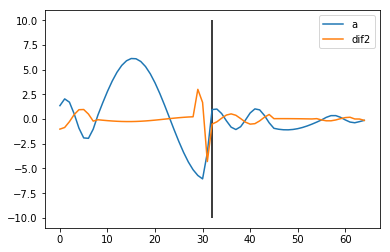

In [18]:
plt.plot(a.numpy(), label='a')
# plt.plot(roll.numpy(), label='roll')
# plt.plot(dif.numpy(), label='dif')
plt.plot(dif2.numpy(), label='dif2')
plt.vlines(src_x, -10, 10)
plt.legend()
plt.show()

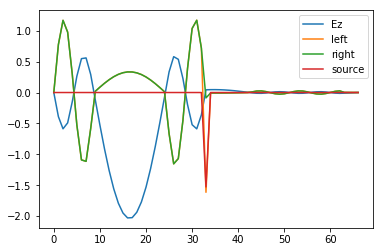

In [19]:
# sourcevals = []
# for i in pbar(range(1000)):

perms = perm_alternating_layers(s=65)
epsilons, src_x, _, _, Ez = Cavity1D(cavity_buffer=16).solve(perms, omega=OMEGA_1550)

a = torch.cat([zero, torch.tensor(np.real(Ez)[16:-16]), zero], dim=-1)
diffs = torch.cat([zero, tensor_diff(a, n=2, padding=None), zero], dim=-1)
# diffs = tensor_diff(a, n=2, cyclic=True)

ez = np.concatenate([[0], np.real(Ez[16:-16]), [0]])

eps = epsilons[16:-16]
barrier = torch.tensor([-1e10]).double()
eps = torch.cat([barrier, torch.tensor(eps), barrier], dim=-1)

# print(a.shape, dif2.shape, ez.shape, eps.shape)

x = PIXEL_SIZE * (np.arange(eps.shape[0]) - src_x)
# Check wave equation terms match
left = SCALE * diffs.numpy() / PIXEL_SIZE**2
right = SCALE * -OMEGA**2 * MU0 * EPSILON0 * eps.numpy() * ez
source = left-right

plt.plot(0.1 * ez, label="Ez")
plt.plot(left, label="left")
plt.plot(right, label="right")

plt.plot(source, label="source")
plt.legend()
plt.show()

# sourcemax = np.max(source[1:-1])
# sourcevals.append(sourcemax)
    

In [3]:
class Perm1dDataset_test(Dataset):
    
    def __init__(self, hdf5_file, batch_name, kernel_sizes = []):
        
        data = load_batch(hdf5_file, batch_name)
        
        self.epsilons = data["epsilons"] 
        self.src = data["src"]
        self.Ez = data["Ez"]
                
        self.input_size = self.Ez[0].shape[0]
        output_size = self.input_size
        for kernel_size in kernel_sizes:
            stride = 1
            output_size = (output_size - kernel_size) / stride + 1
        self.output_size = int(output_size)
        
    def __len__(self):
        return len(self.epsilons)

    def __getitem__(self, i):
        epsilons = torch.tensor(self.epsilons[i])
        src_x = self.src[i]
        fields = torch.tensor(np.imag(self.Ez[i])) # TODO: change to real
        return epsilons.float(), fields.float()

class Perm1dDataset(Dataset):
    
    def __init__(self, epsilon_generator, kernel_sizes = [], N=10000, size=65, infinite_mode=False):
        self.size = size
        self.epsilon_generator = epsilon_generator
        self.epsilon_samples = []
        self.N = N
        self.infinite_mode = infinite_mode
        
    def __len__(self):
        return int(self.N)

    def __getitem__(self, i):
        if i >= len(self.epsilon_samples) or self.infinite_mode:
            epsilons = torch.tensor(self.epsilon_generator())
            if not self.infinite_mode:
                self.epsilon_samples.append(epsilons)
            return epsilons, torch.empty_like(epsilons)
        else:
            epsilons = self.epsilon_samples[i]
            return epsilons, torch.empty_like(epsilons)

In [4]:
class MaxwellDense(nn.Module):
    
    def __init__(self, size=64, src_x=32, supervised=False, drop_p=0.1, regularize_A_phi=True):
        super().__init__()
        
        self.size = size
        self.src_x = src_x
        self.supervised = supervised
        self.regularize_A_phi = regularize_A_phi
        self.drop_p = drop_p

        self.layer_dims = [self.size, 128, 256, 256, 256, 128, self.size]

        layers_amp = []
        layers_phi = []
        for i in range(len(self.layer_dims) - 1):
            layers_amp.append(nn.Linear(self.layer_dims[i], self.layer_dims[i+1]))
            layers_phi.append(nn.Linear(self.layer_dims[i], self.layer_dims[i+1]))
            
        self.layers_amp = nn.ModuleList(layers_amp)
        self.layers_phi = nn.ModuleList(layers_phi)
        
    def forward_amplitude_phase(self, x):
        A = x
        imax = len(self.layers_amp) - 1
        for i, layer in enumerate(self.layers_amp):
            A = layer(A)
            if i < imax:
                A = nn.ReLU()(A)
                A = nn.Dropout(p=self.drop_p)(A)
            else:
                A = nn.ELU()(A) + 1 + 0.1
                
        phi = x
        imax = len(self.layers_phi) - 1
        for i, layer in enumerate(self.layers_phi):
            phi = layer(phi)
            if i < imax:
                phi = nn.ReLU()(phi)
                phi = nn.Dropout(p=0.05)(phi)
            else:
                phi = 2 * np.pi * nn.Tanh()(phi)
        
        return A, phi
    
    def get_fields(self, epsilons, add_zero_bc=False, A_phi=None):
        # Get amplitude and phase vectors
        if A_phi is None:
            A, phi = self.forward_amplitude_phase(epsilons)
        else:
            A, phi = A_phi
            
        # Combine to form waveform
        x = (PIXEL_SIZE * (torch.arange(self.size, dtype=torch.float, device=device) - self.src_x))
        fields = A * torch.cos(OMEGA / C * torch.sqrt(epsilons) * x + phi)
        
        if add_zero_bc:
            batch_size, _ = epsilons.shape
            zero = torch.zeros((batch_size, 1), device=device)  
            fields = torch.cat([zero, fields, zero], dim=-1)
            
        return fields
    
    def forward(self, epsilons):        
        # Compute Ez fields
        A, phi = self.forward_amplitude_phase(epsilons)
        fields = self.get_fields(epsilons, A_phi=(A, phi))
        
        if self.supervised:
            labels = torch.empty_like(fields)
            for i, perm in enumerate(epsilons.detach().numpy()):
                _, _, _, _, Ez = Cavity1D(cavity_buffer=16).solve(perm, omega=OMEGA_1550)
                labels[i, :] = torch.tensor(np.imag(Ez[16:-16])).float()
            return fields - labels
        
        else:
            batch_size, _ = epsilons.shape

            # Add zero field amplitudes at edge points for resonator BC's
            zero = torch.zeros((batch_size, 1), device=device)
            E = torch.cat([zero, fields, zero], dim=-1)

            # Add first layer of cavity BC's
            barrier = torch.full((batch_size, 1), -1e10, device=device)
            eps = torch.cat([barrier, epsilons, barrier], dim=-1)
            
            # Compute Maxwell operator on fields
            diffs = tensor_diff(E, n=2, padding=None)
            curl_curl_E = (SCALE / PIXEL_SIZE**2) * torch.cat([zero, diffs, zero], dim=-1)
            epsilon_E = (SCALE * -OMEGA**2 * MU0 * EPSILON0) * eps * E

            # Compute free-current vector
            J = torch.zeros_like(E)
            J[:,self.src_x + 1] = 1.526814027933079

            out = curl_curl_E - epsilon_E - J
            
            # Penalize excessive variation in A/phi
            if self.regularize_A_phi:
                A_variation = torch.sum(torch.abs(tensor_diff(A)), -1, keepdim=True)
                phi_variation = torch.sum(torch.abs(tensor_diff(phi)), -1, keepdim=True)
                eps_variation = torch.sum(torch.abs(tensor_diff(epsilons)), -1, keepdim=True)
                factor = 1e-1 / (1 + eps_variation)
                out = torch.cat([out, factor*A_variation, factor*phi_variation], dim=-1)
            
            REMOVE_ENDS = True
            if REMOVE_ENDS:
                out = out[:, 1:-1]
            
            return out

In [5]:
class MaxwellConv(nn.Module):
    
    def __init__(self, size=64, src_x=32, supervised=False):
        super().__init__()
        
        self.size = size
        self.src_x = src_x
        self.supervised = supervised
#         
#         self.convnet0 = self.make_convolutional_mininet(1, [128, 256, 128, 1], [3, 3, 3, 3]) # 16 in, 8 out
#         self.convnet1 = self.make_convolutional_mininet(2, [128, 256, 128, 1], [5, 5, 5, 5]) # 32 in, 16 out
#         self.convnet2 = self.make_convolutional_mininet(2, [256, 512, 256, 1], [9, 9, 9, 9]) # 64 in, 32 out
        
        self.convnet = nn.Sequential(
            nn.Conv1d(1, 32, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.Conv1d(32, 16, kernel_size=5, stride=1, padding=0),
            nn.ReLU(),
            nn.Conv1d(16, 1, kernel_size=7, stride=1, padding=0),
            nn.ReLU(),
        )

        self.layer_dims = [64-2-4-6, self.size]

        layers_amp = []
        layers_phi = []
        for i in range(len(self.layer_dims) - 1):
            layers_amp.append(nn.Linear(self.layer_dims[i], self.layer_dims[i+1]))
            layers_phi.append(nn.Linear(self.layer_dims[i], self.layer_dims[i+1], bias=False))
        self.layers_amp = nn.ModuleList(layers_amp)
        self.layers_phi = nn.ModuleList(layers_phi)
        
    @staticmethod
    def make_convolutional_mininet(num_input_channels, channels, kernel_sizes):
        layers = []
        in_channels = num_input_channels
        for out_channels, kernel_size in zip(channels, kernel_sizes):
            layers.append(nn.Conv1d(in_channels, out_channels, kernel_size=kernel_size, stride=1, padding=0))
            layers.append(nn.ReLU())
            in_channels = out_channels
        return nn.Sequential(*layers)
    
    def forward_convolutional(self, epsilons):
        batch_size, eps_size = epsilons.shape
        out = epsilons.view(batch_size, 1, eps_size)
        
        out = self.convnet(out)
        
        out = out.view(batch_size, 64-2-4-6)
        
        return out
        
#         in0 = F.interpolate(eps, scale_factor=1/4)
#         in1 = F.interpolate(eps, scale_factor=1/2)
#         in2 = eps
        
#         out0 = self.convnet0(in0)
        
#         in1 = torch.cat((in1, F.interpolate(out0, scale_factor=4)), 1)
#         out1 = self.convnet1(in1)
        
#         in2 = torch.cat((in2, F.interpolate(out1, scale_factor=4)), 1)
#         out2 = self.convnet2(in2)
        
#         out = out2.view(batch_size, 32)
        
#         return out
        
        
    def forward_amplitude_phase(self, epsilons):
        # Get convolutional output
        x = self.forward_convolutional(epsilons)
        
        A = x
        for i, layer in enumerate(self.layers_amp):
            A = layer(A)
            if i < len(self.layers_amp) - 1:
                A = nn.ReLU()(A)
                
        phi = x
        for i, layer in enumerate(self.layers_phi):
            phi = layer(phi)
            if i < len(self.layers_amp) - 1:
                phi = nn.ReLU()(phi)
        
        return A, phi
    
    def get_fields(self, epsilons):
        # Get amplitude and phase vectors
        A, phi = self.forward_amplitude_phase(epsilons)
            
        # Combine to form waveform
        x = (PIXEL_SIZE * (torch.arange(self.size, dtype=torch.float, device=device) - self.src_x))
        fields = A * torch.cos(OMEGA / C * torch.sqrt(epsilons) * x + phi)
        
        return fields
    
    def forward(self, epsilons):        
        # Compute Ez fields
        fields = self.get_fields(epsilons)
        
        if self.supervised:
            labels = torch.empty_like(fields)
            for i, perm in enumerate(epsilons.detach().numpy()):
                _, _, _, _, Ez = Cavity1D(cavity_buffer=16).solve(perm, omega=OMEGA_1550)
                labels[i, :] = torch.tensor(np.imag(Ez[16:-16])).float()
            return fields - labels
        
        else:
            batch_size, _ = epsilons.shape

            # Add zero field amplitudes at edge points for resonator BC's
            zero = torch.zeros((batch_size, 1), device=device)
            E = torch.cat([zero, fields, zero], dim=-1)

            # Add first layer of cavity BC's
            barrier = torch.full((batch_size, 1), -1e10, device=device)
            eps = torch.cat([barrier, epsilons, barrier], dim=-1)
            
            # Compute Maxwell operator on fields
            diffs = tensor_diff(E, n=2, padding=None)
            curl_curl_E = (SCALE / PIXEL_SIZE**2) * torch.cat([zero, diffs, zero], dim=-1)
            epsilon_E = (SCALE * -OMEGA**2 * MU0 * EPSILON0) * eps * E

            # Compute free-current vector
            J = torch.zeros_like(E)
            J[:,self.src_x + 1] = 1.526814027933079

            out = curl_curl_E - epsilon_E - J
            
            return out

In [9]:
class MaxwellConvV2(nn.Module):
    
    def __init__(self, size=64, src_x=32, drop_p=0.1):
        super().__init__()
        
        self.size = size
        self.src_x = src_x
        self.cavity_buffer=4
        self.total_size = self.size + 2 * self.cavity_buffer
        self.drop_p=drop_p

        c1, c2, c3 = 32, 64, 128
        k1, k2, k3 = 5, 7, 9
        
        self.convnet = nn.Sequential(
            nn.Conv1d(1, c1, kernel_size=k1, stride=1, padding=0),
            nn.ReLU(),
            nn.Dropout(p=self.drop_p),
            nn.Conv1d(c1, c2, kernel_size=k2, stride=1, padding=0),
            nn.ReLU(),
            nn.Dropout(p=self.drop_p),
            nn.Conv1d(c2, c3, kernel_size=k3, stride=1, padding=0),
            nn.ReLU(),
            nn.Dropout(p=self.drop_p)
        )
        out_size = size - (k1-1) - (k2-1) - (k3-1)
        
        self.densenet = nn.Sequential(
            nn.Linear(out_size * c3, out_size * c3),
            nn.ReLU(),
            nn.Dropout(p=self.drop_p),
            nn.Linear(out_size * c3, out_size * c3),
            nn.ReLU(),
            nn.Dropout(p=self.drop_p),
        )

        self.invconvnet = nn.Sequential(
            nn.ConvTranspose1d(c3, c2, kernel_size=k3, stride=1, padding=0),
            nn.ReLU(),
            nn.Dropout(p=self.drop_p),
            nn.ConvTranspose1d(c2, c1, kernel_size=k2, stride=1, padding=0),
            nn.ReLU(),
            nn.ConvTranspose1d(c1, 1, kernel_size=k1, stride=1, padding=0),
        )
        
        curl_op, eps_op = Cavity1D(device_length=self.size, cavity_buffer=self.cavity_buffer).get_operators()
        self.curl_curl_op = torch.tensor([np.asarray(np.real(curl_op))]*batch_size, device=device).float()  
    
    def get_fields(self, epsilons):
        batch_size, L = epsilons.shape
        out = epsilons.view(batch_size, 1, L)
        
        out = self.convnet(out)
        _, c, l2 = out.shape
        
        out = out.view(batch_size, -1)
        out = self.densenet(out)
        
        out = out.view(batch_size, c, l2)
        out = self.invconvnet(out)
        
        out = out.view(batch_size, L)
        
        return out
    
    def forward(self, epsilons):        
        # Compute Ez fields
        fields = self.get_fields(epsilons)
        
        batch_size, _ = epsilons.shape

        # Add zero field amplitudes at edge points for resonator BC's
        E = F.pad(fields, [self.cavity_buffer]*2)
        E = E.view(batch_size, -1, 1)

        # Add first layer of cavity BC's
        eps = F.pad(epsilons, [self.cavity_buffer]*2, "constant", -1e20)
        eps = eps.view(batch_size, -1, 1)

        # Compute Maxwell operator on fields
        curl_curl_E = (SCALE / L0**2) * torch.bmm(self.curl_curl_op, E).view(batch_size, -1, 1)
        epsilon_E = (SCALE * -OMEGA**2 * MU0 * EPSILON0) * eps * E

        # Compute free-current vector
        J = torch.zeros_like(curl_curl_E)
        J[:, self.src_x + self.cavity_buffer, 0] = -1.526814027933079 

        out = curl_curl_E - epsilon_E - J

        return out[:, self.cavity_buffer:-self.cavity_buffer]     

In [10]:
def perm_generator_vacuum():
    return np.ones(65)

In [ ]:
# Hyperparameters
num_epochs = 300
learning_rate = 5e-6
# batch_size = 512
batch_size = 100


# Device configuration
device = torch.device('cuda:0')
# device = torch.device('cpu')

# Create a model   
# model = MaxwellDense(supervised=False, regularize_A_phi=False).to(device)
# model = MaxwellConv(supervised=False).to(device)
model = MaxwellConvV2(drop_p=0.1).to(device)

# writer = SummaryWriter()

# Create data loaders
# train_data = Perm1dDataset(perm_generator_vacuum, N=1, infinite_mode=False)
train_data = Perm1dDataset(perm_random_number_alternating_layers, N=1e6, infinite_mode=False)
train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)

# test_data = Perm1dDataset_test("datasets/test_1d_unsupervised.hdf5", "alternating_layers")
test_data = Perm1dDataset(perm_random_number_alternating_layers, N=1e3, infinite_mode=False)
test_loader = DataLoader(dataset=test_data, batch_size=1, shuffle=False)

# Loss and optimizer
criterion = nn.MSELoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)#, weight_decay=0.001)
# losses = []

# Train the model
model.train()
total_step = len(train_loader)
epoch_iterator = pbar(range(num_epochs))
params = []

for epoch in epoch_iterator:
    
    SHOW_ITERATION_PROGRESS = True
    if SHOW_ITERATION_PROGRESS:
        train_loader = pbar(train_loader)
        
    for epsilons, _ in train_loader:
        
        epsilons = epsilons.float().to(device)
        
        # Forward pass
        outputs = model(epsilons)
        loss = criterion(outputs, torch.zeros_like(outputs))
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()        
        optimizer.step()
        
        if SHOW_ITERATION_PROGRESS:
            train_loader.set_description("ℒ = {:.1e}".format(loss.item()), refresh=False)
    epoch_iterator.set_description("ℒ = {:.1e}".format(loss.item()), refresh=False)

# Save the model checkpoint
torch.save(model.state_dict(), 'model1d.ckpt')

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [26]:
# torch.save(model.state_dict(), 'conv_v2_dec4.ckpt')

In [25]:
# Compute loss on test set

model.eval()  # eval mode (batchnorm uses moving mean/variance instead of mini-batch mean/variance)
test_losses = []

with torch.no_grad():
    for epsilons, _ in pbar(test_loader):
        epsilons = epsilons.float().to(device)
        outputs = model(epsilons)
        loss = criterion(outputs, torch.zeros_like(outputs))
        test_losses.append(loss)

print(f"Mean loss: {np.mean(np.array(test_losses))}")

RuntimeError: invalid argument 7: equal number of batches expected at /opt/conda/conda-bld/pytorch_1532582123400/work/aten/src/THC/generic/THCTensorMathBlas.cu:471

In [ ]:
# model.load_state_dict(torch.load("model1d_nov30_3.ckpt"))

In [13]:
def plot_model_outputs(perms):
    start = time()
    _, src_x, Hx, Hy, Ez = Cavity1D(device_length=64, cavity_buffer=16).solve(perms, omega=OMEGA_1550)
    sim_time = time() - start

    epsilons = torch.tensor([perms]*batch_size, device=device).float()
    start = time()
    fields = model.get_fields(epsilons)
    network_time = time() - start
    
    Ez_pred = fields[0].detach().cpu().numpy()
    scale_ratio = np.mean(np.abs(Ez)) / np.mean(np.abs(Ez_pred))
    Ez_pred *= scale_ratio
    

#     A, phi = model.forward_amplitude_phase(epsilons)

    outputs = model(epsilons)
    loss = criterion(outputs, torch.zeros_like(outputs))
    outputs = outputs[0].detach().cpu().numpy() 
    
    print(f"Error: {np.linalg.norm(outputs)}")
    print(f"Loss: {loss.item()}")

    print("Sim time: {:.5f} | Network time: {:.5f} | Ratio: {:.5f}".format(
        sim_time, network_time, network_time / sim_time))

    f, ax = plt.subplots(2, 1, figsize=(12,12))
    ax[0].plot(epsilons[0].detach().cpu().numpy(), label="Permittivity")
    ax[0].plot(Ez_pred, label="$E_\mathrm{pred}$")
    ax[0].plot(np.real(Ez)[16:-16], label="$E_\mathrm{true}$")
    ax[0].plot(-10 + 20*outputs, label="Model output")
    ax[0].plot(-10 * np.ones(outputs.shape), linestyle=':')
    ax[0].vlines(src_x, -10, 10)
    ax[0].legend()

#     ax[1].plot(A[0].detach().cpu().numpy(), label="$A$")
#     ax[1].plot(phi[0].detach().cpu().numpy(), label="$\phi$")
#     ax[1].plot(np.zeros(outputs.shape), linestyle=':')
#     ax[1].vlines(src_x, -10, 10)
#     ax[1].legend()

    plt.show()

Error: 0.2185598909854889
Loss: 0.0007463820511475205
Sim time: 0.01651 | Network time: 0.00167 | Ratio: 0.10127


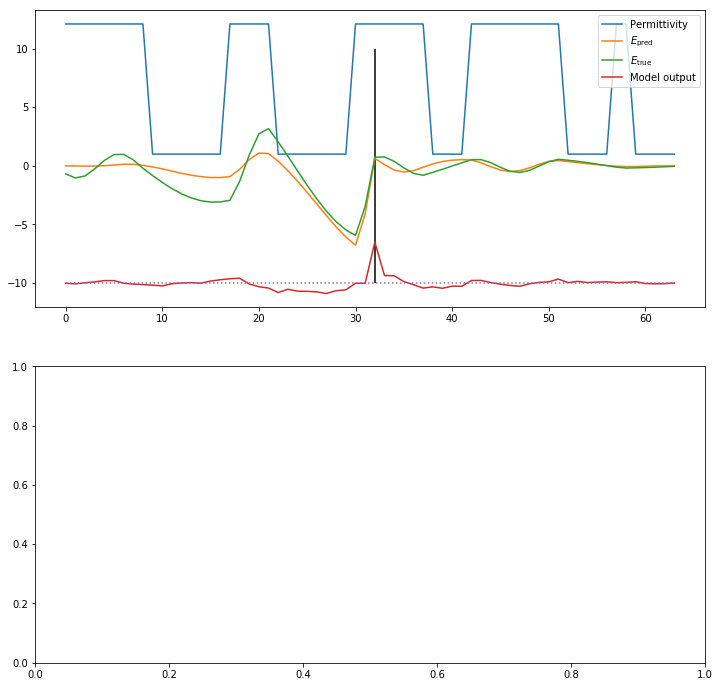

In [46]:
model.eval()
    
# perms = perm_generator_vacuum()
# perms = perm_alternating_layers(s=64)
perms = perm_random_number_alternating_layers()
# perms = train_data[7][0].detach().numpy()
plot_model_outputs(perms)

In [81]:
all_perms = []
for i in pbar(range(10000)):
    perms = perm_random_number_alternating_layers()
    epsilons = torch.tensor([perms], device=device).float()
    outputs = model(epsilons)[0].detach().cpu().numpy()
    err = np.linalg.norm(outputs)
    all_perms.append((err, perms))
all_perms.sort(key=lambda x:x[0])

In [105]:
# for perms in all_perms[0:10]:
#     print(f"Error: {perms[0]}")
#     plot_model_outputs(perms[1])

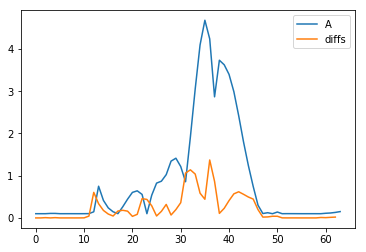

In [30]:
diffs = torch.abs(tensor_diff(A))
plt.plot(A[0].detach().cpu().numpy(), label="A")
plt.plot(diffs[0].detach().cpu().numpy(), label="diffs")
plt.legend()
plt.show()

In [28]:
train_data[0][0]

tensor([12.1104, 12.1104, 12.1104, 12.1104, 12.1104, 12.1104, 12.1104, 12.1104,
        12.1104, 12.1104, 12.1104, 12.1104, 12.1104, 12.1104, 12.1104, 12.1104,
        12.1104, 12.1104, 12.1104, 12.1104, 12.1104, 12.1104, 12.1104, 12.1104,
         2.0736,  2.0736,  2.0736,  2.0736,  2.0736,  2.0736,  2.0736,  2.0736,
         2.0736,  2.0736,  2.0736,  2.0736,  2.0736,  2.0736,  2.0736,  2.0736,
         2.0736,  2.0736,  2.0736, 12.1104, 12.1104, 12.1104, 12.1104, 12.1104,
        12.1104, 12.1104, 12.1104, 12.1104,  2.0736,  2.0736,  2.0736,  2.0736,
         2.0736,  2.0736,  2.0736,  2.0736, 12.1104, 12.1104, 12.1104,  1.0000,
         1.0000], dtype=torch.float64)